# Data analysis
## Running some simple models first

![alt text](https://scikit-learn.org/stable/_static/ml_map.png)


In [1]:
#Setting up environment
import pandas as pd
import os
import numpy as np
from IPython.display import Math
 
import matplotlib.pylab as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV,RandomizedSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier,VotingClassifier,AdaBoostClassifier,GradientBoostingClassifier
from sklearn import metrics, svm,tree,preprocessing
from sklearn.tree import DecisionTreeClassifier
from pprint import pprint
from sklearn.metrics import (auc, confusion_matrix, roc_curve, accuracy_score, precision_score)

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

In [2]:
#Uploading data
df_processed= pd.read_csv("/Suzi fun files/QB course/QB_DS_FinalProject/data/processed/data_all_features.csv", index_col=[0])
df_processed.head()

,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,fractal_dimension_mean,...,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst,diagnosis_category
id,,,,,,,,,,,,,,,,,,,,,
842302,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,...,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890,1
842517,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,...,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902,1
84300903,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,...,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758,1
84348301,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,0.09744,...,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300,1
84358402,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,0.05883,...,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678,1


In [3]:
#Split data into test and train
target = df_processed['diagnosis_category']
X = df_processed.drop('diagnosis_category',axis = 1)
X = X.values
X_train, X_test, y_train, y_test  = train_test_split(X, target, test_size = 0.2,random_state = 42)

In [4]:
df_processed.shape

(569, 31)

## First algorithm: decision tree
- suitable for data with collinearity
- can be visualised 
- our dataset is quite small so computational complexity not a big problem 

I score my grid search with recall, as I want high recall in tumour diagnosis. 

In [5]:
# Tune Decision Tree
num_leaves = [5, 10, 15, 20, 30, 40, 50]
depth = np.arange(3, 21)
num_samples_split = np.arange(10,20)
params_DT = {"max_depth": depth, "min_samples_leaf": num_leaves, "min_samples_split":num_samples_split}
random_state = 42
classifier_DT = DecisionTreeClassifier(random_state=random_state)
grid_DT = GridSearchCV(classifier_DT, params_DT,scoring='roc_auc');
grid_DT.fit(X_train,y_train)

prediction_DT = grid_DT.predict(X_test)
probability_DT = grid_DT.predict_proba(X_test)

In [6]:
grid_DT_df = pd.DataFrame(grid_DT.cv_results_)
grid_DT_df.head(5)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_depth,param_min_samples_leaf,param_min_samples_split,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
0,0.002666,4.722695e-04,0.001001,0.000001,3,5,10,"{'max_depth': 3, 'min_samples_leaf': 5, 'min_s...",0.966831,0.916071,0.92735,0.936883,0.021806,1257
1,0.002000,7.370010e-07,0.000666,0.000471,3,5,11,"{'max_depth': 3, 'min_samples_leaf': 5, 'min_s...",0.966831,0.916071,0.92735,0.936883,0.021806,1257
2,0.002020,1.403006e-05,0.000989,0.000017,3,5,12,"{'max_depth': 3, 'min_samples_leaf': 5, 'min_s...",0.965461,0.916071,0.92735,0.936422,0.021173,1259
3,0.001995,1.167413e-05,0.001005,0.000011,3,5,13,"{'max_depth': 3, 'min_samples_leaf': 5, 'min_s...",0.965461,0.916071,0.92735,0.936422,0.021173,1259
4,0.002002,2.245020e-06,0.001000,0.000002,3,5,14,"{'max_depth': 3, 'min_samples_leaf': 5, 'min_s...",0.969846,0.916071,0.92735,0.937897,0.023200,1256


In [7]:
print("Accuracy:",metrics.accuracy_score(y_test, prediction_DT))

Accuracy: 0.9473684210526315


[Text(558.0, 489.24, 'concave points_mean <= 0.051\nsamples = 100.0%\nvalue = [0.629, 0.371]'),
 Text(343.38461538461536, 380.52000000000004, 'radius_worst <= 16.83\nsamples = 62.0%\nvalue = [0.943, 0.057]'),
 Text(257.53846153846155, 271.8, 'area_se <= 34.405\nsamples = 57.8%\nvalue = [0.981, 0.019]'),
 Text(171.69230769230768, 163.08000000000004, 'texture_worst <= 30.145\nsamples = 54.5%\nvalue = [0.992, 0.008]'),
 Text(85.84615384615384, 54.360000000000014, 'samples = 47.5%\nvalue = [1.0, 0.0]'),
 Text(257.53846153846155, 54.360000000000014, 'samples = 7.0%\nvalue = [0.938, 0.062]'),
 Text(343.38461538461536, 163.08000000000004, 'samples = 3.3%\nvalue = [0.8, 0.2]'),
 Text(429.23076923076917, 271.8, 'samples = 4.2%\nvalue = [0.421, 0.579]'),
 Text(772.6153846153845, 380.52000000000004, 'concave points_worst <= 0.147\nsamples = 38.0%\nvalue = [0.116, 0.884]'),
 Text(600.9230769230769, 271.8, 'fractal_dimension_mean <= 0.063\nsamples = 7.7%\nvalue = [0.514, 0.486]'),
 Text(515.0769230

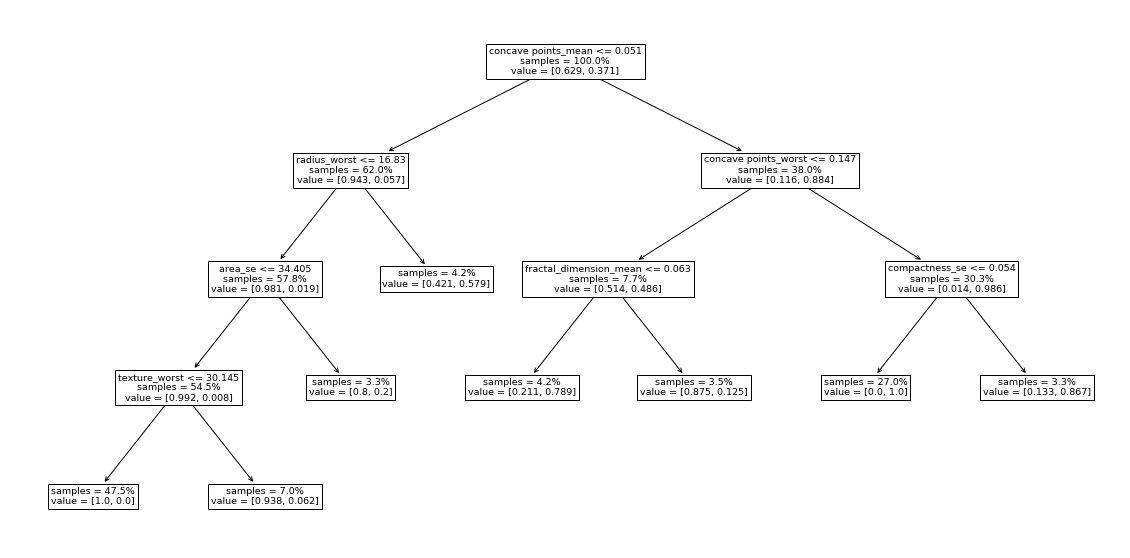

In [8]:
model_DT= grid_DT.best_estimator_
plt.figure(figsize=(20,10)) 
tree.plot_tree(model_DT, feature_names=df_processed.columns[0:-1], impurity=False, proportion=True)

In [9]:
print(metrics.confusion_matrix(y_test, prediction_DT))

[[68  3]
 [ 3 40]]


In [10]:
tree_tn, tree_fp, tree_fn, tree_tp = metrics.confusion_matrix(y_test, prediction_DT).ravel()
recall_DT= tree_tp/(tree_tp + tree_fn)
precision_DT = tree_tp/(tree_tp + tree_fp)
print(recall_DT)
print(precision_DT)

0.9302325581395349
0.9302325581395349


{'max_depth': 4, 'min_samples_leaf': 15, 'min_samples_split': 10}


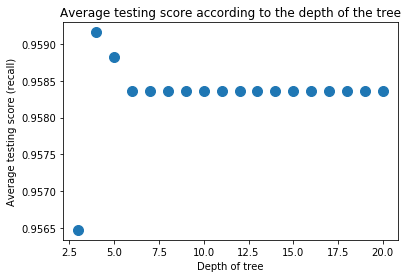

In [11]:
plt.plot(grid_DT_df[['mean_test_score', 'param_max_depth']].groupby('param_max_depth').mean(), 
         marker='o', linestyle='None', markersize = 10.0)
plt.xlabel('Depth of tree')
plt.ylabel('Average testing score (recall)')
plt.title('Average testing score according to the depth of the tree')

print(grid_DT.best_params_)

## That's my decision tree done.
## Let's try another non-parametric algorithm, support vector machines. 

For SVM, I need to normalise my data for zero mean and unit variance. 

Some info on SVM https://statinfer.com/204-6-8-svm-advantages-disadvantages-applications/

Application to this dataset https://towardsdatascience.com/breast-cancer-classification-using-support-vector-machine-svm-a510907d4878

Tuning inspired by https://medium.com/@aneesha/svm-parameter-tuning-in-scikit-learn-using-gridsearchcv-2413c02125a0

In [12]:
X_train_scaled = preprocessing.scale(X_train)
X_test_scaled  = preprocessing.scale(X_test)

In [13]:
# Tune support vector machine
kernels = ['linear','poly','rbf']
Cs = [0.01, 0.1, 1, 10, 100]
gammas = [0.001, 0.01, 0.1, 1]
params_SVM = {"kernel": ['linear'], "C":Cs}
{"kernel" : ['poly'],"gamma": gammas, "C":Cs}
{"kernel" : ['rbf'],"gamma": gammas, "C":Cs}
classifier_SVM = svm.SVC(probability=True)
grid_SVM = GridSearchCV(classifier_SVM,params_SVM,scoring='roc_auc')
grid_SVM.fit(X_train_scaled,y_train)

GridSearchCV(cv='warn', error_score='raise-deprecating',
             estimator=SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
                           decision_function_shape='ovr', degree=3,
                           gamma='auto_deprecated', kernel='rbf', max_iter=-1,
                           probability=True, random_state=None, shrinking=True,
                           tol=0.001, verbose=False),
             iid='warn', n_jobs=None,
             param_grid={'C': [0.01, 0.1, 1, 10, 100], 'kernel': ['linear']},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring='roc_auc', verbose=0)

In [14]:
grid_SVM_df = pd.DataFrame(grid_SVM.cv_results_)
grid_SVM_df.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_C,param_kernel,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
0,0.004345,0.000484,0.000977,0.000018,0.01,linear,"{'C': 0.01, 'kernel': 'linear'}",0.997807,0.983459,0.993609,0.991652,0.006024,2
1,0.003354,0.000478,0.001332,0.000472,0.1,linear,"{'C': 0.1, 'kernel': 'linear'}",0.998721,0.985150,0.994549,0.992833,0.005676,1
2,0.004324,0.000479,0.000667,0.000471,1,linear,"{'C': 1, 'kernel': 'linear'}",0.997807,0.981015,0.977632,0.985539,0.008840,3
3,0.006663,0.001704,0.001003,0.000009,10,linear,"{'C': 10, 'kernel': 'linear'}",0.992142,0.969173,0.971992,0.977832,0.010250,4
4,0.009001,0.003559,0.000999,0.000023,100,linear,"{'C': 100, 'kernel': 'linear'}",0.987025,0.966165,0.971992,0.975114,0.008804,5


In [15]:
prediction_SVM = grid_SVM.predict(X_test_scaled)
probability_SVM = grid_SVM.predict_proba(X_test_scaled)
print(grid_SVM.best_params_)
print("Accuracy:",metrics.accuracy_score(y_test, prediction_SVM))
print(metrics.confusion_matrix(y_test, prediction_SVM))

{'C': 0.1, 'kernel': 'linear'}
Accuracy: 0.9824561403508771
[[71  0]
 [ 2 41]]


In [49]:
svm_tn, svm_fp, svm_fn, svm_tp = metrics.confusion_matrix(y_test, prediction_SVM).ravel()
recall_SVM = svm_tp/(svm_tp + svm_fn)
precision_SVM = svm_tp/(svm_tp + svm_fp)
print(recall_SVM)
print(precision_SVM)

0.9534883720930233
1.0


### As my SVM model uses a linear kernel, I can assess feature importance
taken from https://stackoverflow.com/questions/41592661/determining-the-most-contributing-features-for-svm-classifier-in-sklearn

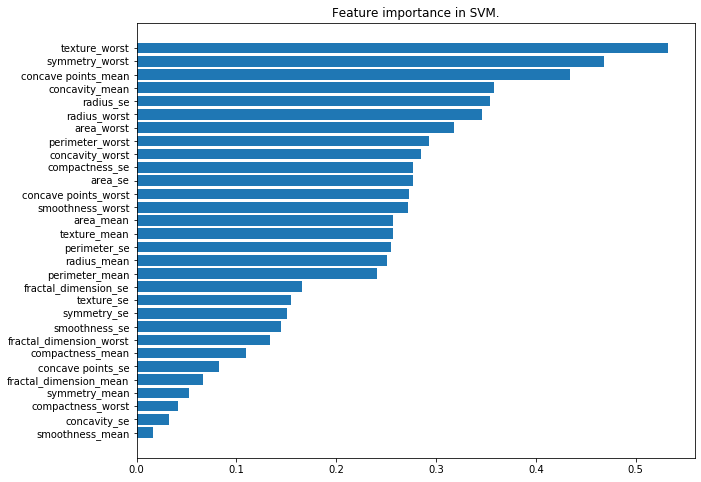

In [17]:
def f_importances(coef,estimator, names, top=-1):
    imp = coef
    imp, names = zip(*sorted(list(zip(imp, names))))

    if top == -1:
        top = len(names)
    plt.figure(figsize=(10,8))
    plt.barh(range(top), imp[::-1][0:top], align='center')
    plt.yticks(range(top), names[::-1][0:top])
    plt.title("Feature importance in {}.".format(estimator))
    plt.gca().invert_yaxis()
    plt.show()

features_names = list(df_processed.columns)    
model_SVM = grid_SVM.best_estimator_
f_importances(abs(model_SVM.coef_[0]),"SVM", features_names, top=-1)


## K-nearest neighbours, popular with this dataset
See https://www.geeksforgeeks.org/ml-kaggle-breast-cancer-wisconsin-diagnosis-using-knn/ or *Sarkar M, Leong TY. Application of K-nearest neighbors algorithm on breast cancer diagnosis problem. Proc AMIA Symp. 2000;759–763.*

In [18]:
# Tune KNN
neighbours = [5,10,15,20]
power_parameter = [1,2]
params_KNN = {"n_neighbors": neighbours, "p": power_parameter}
classifier_KNN = KNeighborsClassifier()
grid_KNN = GridSearchCV(classifier_KNN,params_KNN,scoring='roc_auc')
grid_KNN.fit(X_train_scaled,y_train)

GridSearchCV(cv='warn', error_score='raise-deprecating',
             estimator=KNeighborsClassifier(algorithm='auto', leaf_size=30,
                                            metric='minkowski',
                                            metric_params=None, n_jobs=None,
                                            n_neighbors=5, p=2,
                                            weights='uniform'),
             iid='warn', n_jobs=None,
             param_grid={'n_neighbors': [5, 10, 15, 20], 'p': [1, 2]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring='roc_auc', verbose=0)

In [19]:
prediction_KNN = grid_KNN.predict(X_test_scaled)
probability_KNN = grid_KNN.predict_proba(X_test_scaled)
print(grid_KNN.best_params_)
print("Accuracy:",metrics.accuracy_score(y_test, prediction_KNN))
print(metrics.confusion_matrix(y_test, prediction_KNN))

{'n_neighbors': 20, 'p': 2}
Accuracy: 0.956140350877193
[[70  1]
 [ 4 39]]


In [20]:
knn_tn, knn_fp, knn_fn, knn_tp = metrics.confusion_matrix(y_test, prediction_KNN).ravel()
recall_KNN = knn_tp/(knn_tp + knn_fn)
precision_KNN = knn_tp/(knn_tp + knn_fp)
print(recall_KNN)
print(precision_KNN)

0.9069767441860465
0.975


## A simple ensemble model: combine my KNN and SVM
using the best parameters from my grid search

In [21]:
model_KNN= grid_KNN.best_estimator_
model_SVM= grid_SVM.best_estimator_
classifier_SVM_KNN = VotingClassifier(estimators = [('knn',model_KNN),('svm',model_SVM)],voting = 'soft')
classifier_SVM_KNN.fit(X_train_scaled,y_train)

VotingClassifier(estimators=[('knn',
                              KNeighborsClassifier(algorithm='auto',
                                                   leaf_size=30,
                                                   metric='minkowski',
                                                   metric_params=None,
                                                   n_jobs=None, n_neighbors=20,
                                                   p=2, weights='uniform')),
                             ('svm',
                              SVC(C=0.1, cache_size=200, class_weight=None,
                                  coef0=0.0, decision_function_shape='ovr',
                                  degree=3, gamma='auto_deprecated',
                                  kernel='linear', max_iter=-1,
                                  probability=True, random_state=None,
                                  shrinking=True, tol=0.001, verbose=False))],
                 flatten_transform=True, n_jobs=None, voti

In [22]:
prediction_SVM_KNN = classifier_SVM_KNN.predict(X_test_scaled)
probability_SVM_KNN = classifier_SVM_KNN.predict_proba(X_test_scaled)
print("Accuracy:",metrics.accuracy_score(y_test, prediction_SVM_KNN))
print(metrics.confusion_matrix(y_test, prediction_SVM_KNN))

Accuracy: 0.9736842105263158
[[71  0]
 [ 3 40]]


In [23]:
svm_knn_tn, svm_knn_fp, svm_knn_fn, svm_knn_tp = metrics.confusion_matrix(y_test, prediction_SVM_KNN).ravel()
recall_SVM_KNN = svm_knn_tp/(svm_knn_tp + svm_knn_fn)
precision_SVM_KNN = svm_knn_tp/(svm_knn_tp + svm_knn_fp)
print(recall_SVM_KNN)
print(precision_SVM_KNN)

0.9302325581395349
1.0


## Bagging: Random Forest

In [24]:
# Tune RF
n_estimators = [int(x) for x in np.linspace(start = 50, stop = 150, num = 11)]
max_features = ['auto', 'sqrt','log2']
max_depth = [int(x) for x in np.linspace(5, 55, num = 11)]
min_samples_split = [2, 5, 10]
min_samples_leaf = [10, 20, 30, 40]
bootstrap = [True,False]
params_RF = {'n_estimators': n_estimators,'max_features':max_features,'max_depth':max_depth,
             'min_samples_split':min_samples_split,'min_samples_leaf':min_samples_leaf,'bootstrap':bootstrap}
classifier_RF = RandomForestClassifier()
grid_RF = RandomizedSearchCV(classifier_RF,params_RF,n_iter = 300,scoring='roc_auc',random_state=random_state,n_jobs = -1,cv=5,verbose=2)
grid_RF.fit(X_train,y_train)

Fitting 5 folds for each of 300 candidates, totalling 1500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    2.7s
[Parallel(n_jobs=-1)]: Done 138 tasks      | elapsed:    4.1s
[Parallel(n_jobs=-1)]: Done 381 tasks      | elapsed:    6.8s
[Parallel(n_jobs=-1)]: Done 947 tasks      | elapsed:   13.0s
[Parallel(n_jobs=-1)]: Done 1477 out of 1500 | elapsed:   18.7s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done 1500 out of 1500 | elapsed:   18.9s finished


RandomizedSearchCV(cv=5, error_score='raise-deprecating',
                   estimator=RandomForestClassifier(bootstrap=True,
                                                    class_weight=None,
                                                    criterion='gini',
                                                    max_depth=None,
                                                    max_features='auto',
                                                    max_leaf_nodes=None,
                                                    min_impurity_decrease=0.0,
                                                    min_impurity_split=None,
                                                    min_samples_leaf=1,
                                                    min_samples_split=2,
                                                    min_weight_fraction_leaf=0.0,
                                                    n_estimators='warn',
                                                    n_jobs=None

In [25]:
prediction_RF =grid_RF.predict(X_test)
probability_RF = grid_RF.predict_proba(X_test)
print(grid_RF.best_params_)
print("Accuracy:",metrics.accuracy_score(y_test, prediction_RF))
print(metrics.confusion_matrix(y_test, prediction_RF))

{'n_estimators': 130, 'min_samples_split': 2, 'min_samples_leaf': 10, 'max_features': 'log2', 'max_depth': 20, 'bootstrap': False}
Accuracy: 0.9649122807017544
[[70  1]
 [ 3 40]]


In [26]:
rf_tn, rf_fp, rf_fn, rf_tp = metrics.confusion_matrix(y_test, prediction_RF).ravel()
recall_RF = rf_tp/(rf_tp + rf_fn)
precision_RF = rf_tp/(rf_tp + rf_fp)
print(recall_RF)
print(precision_RF)

0.9302325581395349
0.975609756097561


### Random Forest feature importance
https://blog.datadive.net/selecting-good-features-part-iii-random-forests/

In [27]:
print ("Features sorted by their score(decrease of impurity):")
print (sorted(zip(map(lambda x: round(x, 4), grid_RF.best_estimator_.feature_importances_), features_names), 
             reverse=True))

Features sorted by their score(decrease of impurity):
[(0.1353, 'concave points_mean'), (0.1282, 'radius_worst'), (0.1073, 'area_worst'), (0.0992, 'concave points_worst'), (0.0796, 'area_mean'), (0.0653, 'perimeter_worst'), (0.0611, 'concavity_mean'), (0.0559, 'perimeter_mean'), (0.0555, 'radius_mean'), (0.0528, 'concavity_worst'), (0.0257, 'area_se'), (0.0235, 'compactness_worst'), (0.0188, 'radius_se'), (0.0147, 'texture_worst'), (0.014, 'texture_mean'), (0.0129, 'perimeter_se'), (0.0117, 'symmetry_worst'), (0.0059, 'concavity_se'), (0.0054, 'smoothness_worst'), (0.0053, 'compactness_mean'), (0.0041, 'fractal_dimension_worst'), (0.0037, 'smoothness_mean'), (0.0036, 'compactness_se'), (0.0022, 'fractal_dimension_se'), (0.0022, 'fractal_dimension_mean'), (0.002, 'symmetry_se'), (0.0015, 'concave points_se'), (0.001, 'texture_se'), (0.0008, 'smoothness_se'), (0.0007, 'symmetry_mean')]


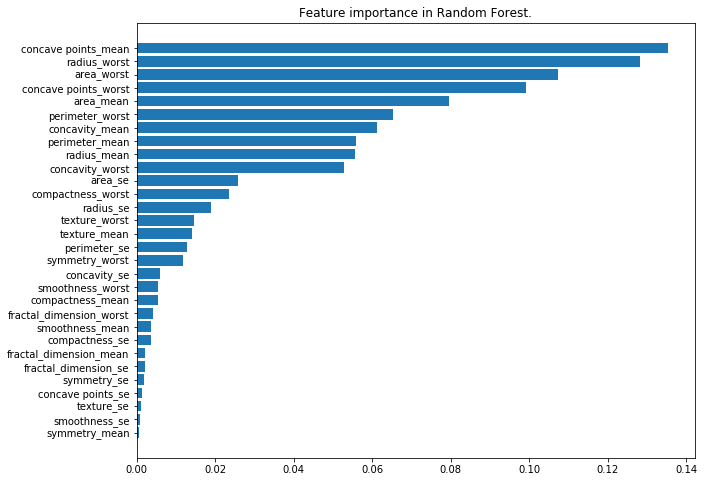

In [28]:
f_importances(abs(grid_RF.best_estimator_.feature_importances_),"Random Forest", features_names, top=-1)

## Boosting: AdaBoost
mostly used on Decision trees https://machinelearningmastery.com/boosting-and-adaboost-for-machine-learning/

In [44]:
params_AB = {
 'n_estimators': [20, 50, 100],
 'learning_rate' : [0.01,0.05,0.1,0.3,1]}
classifier_AB = AdaBoostClassifier(random_state=random_state)
grid_AB = RandomizedSearchCV(classifier_AB,params_AB,n_iter = 300,scoring='roc_auc',random_state=random_state,n_jobs = -1,cv=5,verbose=0)
grid_AB.fit(X_train,y_train);

In [45]:
prediction_AB = grid_AB.predict(X_test)
probability_AB = grid_AB.predict_proba(X_test)
print("Accuracy:",metrics.accuracy_score(y_test, prediction_AB))
print(metrics.confusion_matrix(y_test, prediction_AB))

Accuracy: 0.9736842105263158
[[70  1]
 [ 2 41]]


In [46]:
ab_tn, ab_fp, ab_fn, ab_tp = metrics.confusion_matrix(y_test, prediction_AB).ravel()
recall_AB = ab_tp/(ab_tp + ab_fn)
precision_AB = ab_tp/(ab_tp + ab_fp)
print(recall_AB)
print(precision_AB)

0.9534883720930233
0.9761904761904762


## Gradient boosting
tuning: https://www.analyticsvidhya.com/blog/2016/02/complete-guide-parameter-tuning-gradient-boosting-gbm-python/

In [32]:
# Tuning with same parameters as my random forest
learning_rate = [0.1, 0.2, 0.3];
params_GB = {'learning_rate': learning_rate,'n_estimators': n_estimators,'max_features':max_features,'max_depth':max_depth,
             'min_samples_split':min_samples_split,'min_samples_leaf':min_samples_leaf}
classifier_GB = GradientBoostingClassifier()
grid_GB = RandomizedSearchCV(classifier_GB,params_GB,n_iter = 300,scoring='roc_auc',random_state=random_state,n_jobs = -1,cv=5,verbose=2)
grid_GB.fit(X_train,y_train)

Fitting 5 folds for each of 300 candidates, totalling 1500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 480 tasks      | elapsed:    4.0s
[Parallel(n_jobs=-1)]: Done 1292 tasks      | elapsed:   11.1s
[Parallel(n_jobs=-1)]: Done 1500 out of 1500 | elapsed:   13.2s finished


RandomizedSearchCV(cv=5, error_score='raise-deprecating',
                   estimator=GradientBoostingClassifier(criterion='friedman_mse',
                                                        init=None,
                                                        learning_rate=0.1,
                                                        loss='deviance',
                                                        max_depth=3,
                                                        max_features=None,
                                                        max_leaf_nodes=None,
                                                        min_impurity_decrease=0.0,
                                                        min_impurity_split=None,
                                                        min_samples_leaf=1,
                                                        min_samples_split=2,
                                                        min_weight_fraction_leaf=0.0,
                     

In [33]:
prediction_GB = grid_GB.predict(X_test)
probability_GB = grid_GB.predict_proba(X_test)
print(grid_GB.best_params_)
print("Accuracy:",metrics.accuracy_score(y_test, prediction_GB))
print(metrics.confusion_matrix(y_test, prediction_GB))

{'n_estimators': 140, 'min_samples_split': 2, 'min_samples_leaf': 40, 'max_features': 'sqrt', 'max_depth': 45, 'learning_rate': 0.2}
Accuracy: 0.9649122807017544
[[70  1]
 [ 3 40]]


In [34]:
gb_tn, gb_fp, gb_fn, gb_tp = metrics.confusion_matrix(y_test, prediction_GB).ravel()
recall_GB = gb_tp/(gb_tp + gb_fn)
precision_GB = gb_tp/(gb_tp + gb_fp)
print(recall_GB)
print(precision_GB)

0.9302325581395349
0.975609756097561


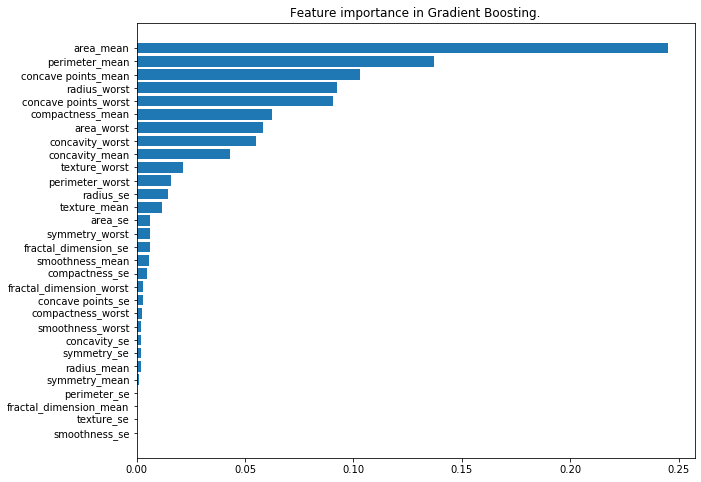

In [35]:
f_importances(abs(grid_GB.best_estimator_.feature_importances_),"Gradient Boosting", features_names, top=-1)

## Compare all models

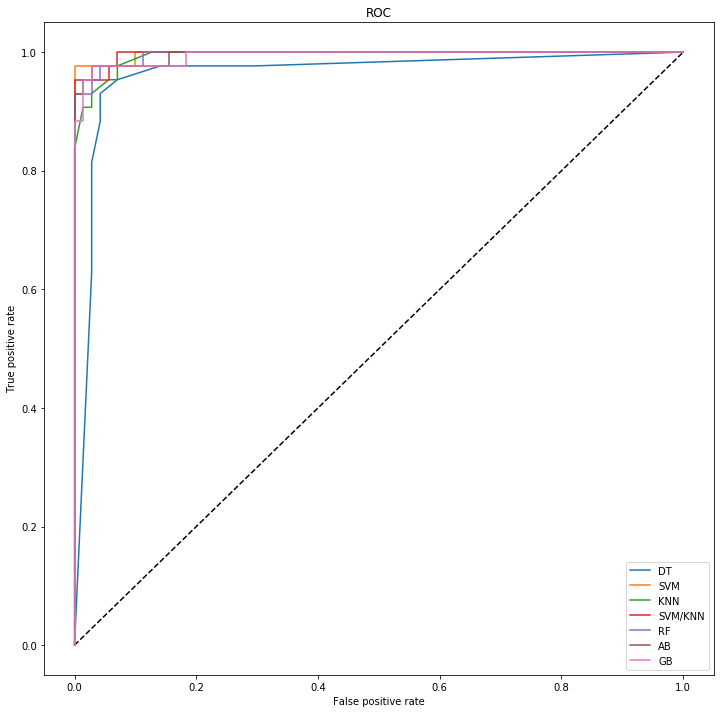

In [47]:
false_pos_rate_DT,true_pos_rate_DT, thresholds_DT = roc_curve(y_test, probability_DT[:, 1])
false_pos_rate_SVM,true_pos_rate_SVM, thresholds_SVM = roc_curve(y_test, probability_SVM[:, 1])
false_pos_rate_KNN,true_pos_rate_KNN, thresholds_KNN = roc_curve(y_test, probability_KNN[:, 1])
false_pos_rate_SVM_KNN,true_pos_rate_SVM_KNN, thresholds_SVM_KNN = roc_curve(y_test, probability_SVM_KNN[:, 1])
false_pos_rate_RF,true_pos_rate_RF, thresholds_RF = roc_curve(y_test, probability_RF[:, 1])
false_pos_rate_AB,true_pos_rate_AB, thresholds_AB = roc_curve(y_test, probability_AB[:, 1])
false_pos_rate_GB,true_pos_rate_GB, thresholds_GB = roc_curve(y_test, probability_GB[:, 1])

# Plot the ROC curve
fig = plt.figure(figsize=(12,12))
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(false_pos_rate_DT, true_pos_rate_DT, label='DT')
plt.plot(false_pos_rate_SVM, true_pos_rate_SVM, label='SVM')
plt.plot(false_pos_rate_KNN, true_pos_rate_KNN, label='KNN')
plt.plot(false_pos_rate_SVM_KNN, true_pos_rate_SVM_KNN, label='SVM/KNN')
plt.plot(false_pos_rate_RF, true_pos_rate_RF, label='RF')
plt.plot(false_pos_rate_AB, true_pos_rate_AB, label='AB')
plt.plot(false_pos_rate_GB, true_pos_rate_GB, label='GB')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC')
plt.legend(loc='best')
plt.show()

In [37]:
print(thresholds_DT)
print(thresholds_SVM)
print(thresholds_KNN)

[2.         1.         0.86666667 0.78947368 0.57894737 0.2
 0.125      0.0625     0.        ]
[2.00000000e+00 1.00000000e+00 3.57269956e-01 7.38178983e-02
 7.10300366e-02 2.67327209e-06]
[2.   1.   0.95 0.9  0.85 0.8  0.75 0.65 0.6  0.5  0.45 0.3  0.2  0.15
 0.1  0.05 0.  ]


In [48]:
# Summary
print("Accuracy DT:",metrics.accuracy_score(y_test, prediction_DT)*100,"Recall DT:",recall_DT*100,"AOC DT:",metrics.auc(false_pos_rate_DT, true_pos_rate_DT),"Precision DT:",precision_DT*100)
print("Accuracy SVM:",metrics.accuracy_score(y_test, prediction_SVM)*100,"Recall SVM:",recall_SVM*100,"AOC SVM:",metrics.auc(false_pos_rate_SVM, true_pos_rate_SVM),"Precision SVM:",precision_SVM*100)
print("Accuracy KNN:",metrics.accuracy_score(y_test, prediction_KNN)*100,"Recall KNN:",recall_KNN*100,"AOC KNN:",metrics.auc(false_pos_rate_KNN, true_pos_rate_KNN),"Precision KNN:",precision_KNN*100)
print("Accuracy SVM/KNN:",metrics.accuracy_score(y_test, prediction_SVM_KNN)*100,"Recall SVM/KNN:",recall_SVM_KNN*100,"AOC SVM_KNN:",metrics.auc(false_pos_rate_SVM_KNN, true_pos_rate_SVM_KNN),"Precision SVM/KNN:",precision_SVM_KNN*100)
print("Accuracy RF:",metrics.accuracy_score(y_test, prediction_RF)*100,"Recall RF:",recall_RF*100,"AOC RF:",metrics.auc(false_pos_rate_RF, true_pos_rate_RF),"Precision RF:",precision_RF*100)
print("Accuracy AB:",metrics.accuracy_score(y_test, prediction_AB)*100,"Recall AB:",recall_AB*100,"AOC AB:",metrics.auc(false_pos_rate_AB, true_pos_rate_AB),"Precision AB:",precision_AB*100)
print("Accuracy GB:",metrics.accuracy_score(y_test, prediction_GB)*100,"Recall GB:",recall_GB*100,"AOC GB:",metrics.auc(false_pos_rate_GB, true_pos_rate_GB),"Precision GB:",precision_GB*100)

Accuracy DT: 94.73684210526315 Recall DT: 93.02325581395348 AOC DT: 0.962659679004258 Precision DT: 93.02325581395348
Accuracy SVM: 98.24561403508771 Recall SVM: 95.34883720930233 AOC SVM: 0.9977071732721913 Precision SVM: 93.02325581395348
Accuracy KNN: 95.6140350877193 Recall KNN: 90.69767441860465 AOC KNN: 0.993940386505077 Precision KNN: 97.5
Accuracy SVM/KNN: 97.36842105263158 Recall SVM/KNN: 93.02325581395348 AOC SVM_KNN: 0.9970520799213888 Precision SVM/KNN: 100.0
Accuracy RF: 96.49122807017544 Recall RF: 93.02325581395348 AOC RF: 0.9957418932197839 Precision RF: 97.5609756097561
Accuracy AB: 97.36842105263158 Recall AB: 95.34883720930233 AOC AB: 0.9954143465443825 Precision AB: 97.61904761904762
Accuracy GB: 96.49122807017544 Recall GB: 93.02325581395348 AOC GB: 0.9941041598427777 Precision GB: 97.5609756097561


## Save my test and train data for use in different notebooks

In [39]:
type(X_test)

numpy.ndarray

In [40]:
type(y_train)

pandas.core.series.Series

In [41]:
print(y_train)
type(y_train)

id
859471      0
873593      1
859196      0
88466802    0
858970      0
           ..
859711      0
863031      0
8910721     0
908489      1
862965      0
Name: diagnosis_category, Length: 455, dtype: int64


pandas.core.series.Series

In [42]:
#y_train.to_csv("/Suzi fun files/QB course/QB_DS_FinalProject/data/interim/y_train.csv")
#y_test.to_csv("/Suzi fun files/QB course/QB_DS_FinalProject/data/interim/y_test.csv")

In [43]:
#pd.DataFrame(X_test).to_csv("/Suzi fun files/QB course/QB_DS_FinalProject/data/interim/X_test.csv")
#pd.DataFrame(X_train).to_csv("/Suzi fun files/QB course/QB_DS_FinalProject/data/interim/X_train.csv")